# ConvLstm examples on Opportunity Dataset -` gesture` only

In [1]:
import numpy as np
import scipy.io # load the matrix file
import pickle as cp
 
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.core import Permute, Reshape
from keras import backend as K
from keras.callbacks import TensorBoard 

from sklearn.model_selection import train_test_split
# example: X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


/Users/chentailin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1. Prepare the dataset `OPPORTUNITY Activity Recognition Data Set ` 

## 1. Wearable Sensor Data

In [2]:

def load_dataset(filename):
    """
    Function to load dataset 
    
    Argument:
        filename : the path of the preprocessed dataset
    
    Return:
    
        X_train
        y_train
        X_test
        y_test
        
    Notice:
        Need use `pickle(python3)` or`cpicckle(python2)` module to load and read dataset.
        
    
    """

    f = open(filename, 'rb')
    data = cp.load(f)
    f.close()

    X_train, y_train = data[0]
    X_test, y_test = data[1]

    print(" ..from file {}".format(filename))
    print(" ..reading instances: X_train {0}, X_test {1}".format(X_train.shape, X_test.shape))
    print(" ..reading instances: y_train {0}, y_test {1}".format(y_train.shape, y_test.shape))

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # The targets are casted to int8 for GPU compatibility.
    y_train = y_train.astype(np.uint8)
    y_test = y_test.astype(np.uint8)

    return X_train, y_train, X_test, y_test

print("Loading data...")
X_train, y_train, X_test, y_test = load_dataset('DeepConvLSTM/data/oppChallenge_gestures.data')
print("Successfully")


Loading data...
 ..from file DeepConvLSTM/data/oppChallenge_gestures.data
 ..reading instances: X_train (557963, 113), X_test (118750, 113)
 ..reading instances: y_train (557963,), y_test (118750,)
Successfully


In [3]:
y_train.max()
print("17 activities and 1 NaN classes")

17 activities and 1 NaN classes


In [4]:
# Opportunity num_classes = 18
num_classes = 18

In [5]:
# y_train = to_categorical(y_train,num_classes=num_classes)
# y_test = to_categorical(y_test,num_classes)

In [6]:
print(X_train.shape)
print(y_train.shape)

(557963, 113)
(557963,)


# 2.Now, we have `X_train, A_train, X_test, A_test, y_train, y_test`

## 很显然我们需要用`sliding_window `来处理 `X_train` 和 `y_train` ，`A_train`&`A_test` to get the features
    1.参考Kronecker Product fusion method 来实验
        - 实验只用raw feature
        - 对比混合了attribute 的方法
    2. define `sliding_window`
    3. using sliding_window to process raw data into (rows,window_size,dimensions)


In [7]:
from sliding_window import sliding_window
# ?sliding_window

# assert NB_SENSOR_CHANNELS == X_train.shape[1]
def opp_sliding_window(data_x, data_y, ws, ss):
    data_x = sliding_window(a=data_x,ws=(ws,data_x.shape[1]),ss=(ss,1),flatten=False)
#     data_x = sliding_window(data_x,ws,ss)

    data_y = np.asarray([[i[-1]] for i in sliding_window(data_y,ws,ss,flatten=False)])
    return data_x.reshape(-1,ws,data_x.shape[3]).astype(np.float32), data_y.reshape(-1).astype(np.uint8)
#     return data_x.astype(np.float32), data_y.flatten().astype(np.uint8)

SLIDING_WINDOW_LENGTH = 24
SLIDING_WINDOW_STEP = 12

In [8]:
# Use sliding_window to choose samples

X_train0, y_train0 = opp_sliding_window(X_train, y_train, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)
print(" ..after sliding window (training): inputs {0}, targets {1}".format(X_train0.shape, y_train0.shape))

X_test0, y_test0 = opp_sliding_window(X_test, y_test, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)
print(" ..after sliding window (testing): inputs {0}, targets {1}".format(X_test0.shape, y_test0.shape))


 ..after sliding window (training): inputs (46495, 24, 113), targets (46495,)
 ..after sliding window (testing): inputs (9894, 24, 113), targets (9894,)


In [9]:
y_train1 = to_categorical(y_train0,num_classes)
y_test1 = to_categorical(y_test0,num_classes)

In [10]:
y_test0.shape
y_train1.shape

(46495, 18)

# 2. Define the `ConvLstm` Model

In [11]:
def model_variant(model, num_feat_map, dim, network_type):
    print(network_type)
    if network_type == 'ConvLSTM':
        model.add(Permute((2, 1, 3))) # for swap-dimension
        model.add(Reshape((-1,num_feat_map*dim)))
        model.add(LSTM(32, return_sequences=False, stateful=False))
        model.add(Dropout(0.2))
    if network_type == 'CNN':
         
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))

def model_conv(model, num_feat_map):
    model.add(Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(num_feat_map, 
                     kernel_size=(1, 5), 
                     activation='relu',
                     padding='same'))
    
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.2))
     

def model_LSTM(model):
    model.add(LSTM(num_hidden_lstm, 
               input_shape=(win_len,dim), 
               return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(num_hidden_lstm, return_sequences=False))
    model.add(Dropout(0.2))

# def model_LSTM(model):
    

# ### def model_MLP(model, num_hidden_mlp):
#     model.add(Dense(num_hidden_mlp, activation='relu', input_shape=(dim*win_len,)))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_hidden_mlp, activation='relu'))
#     model.add(Dropout(0.5))

def model_output(model):
    model.add(Dense(num_classes, activation='softmax'))

In [12]:
batch_size = 128
num_feat_map = 16
num_hidden_mlp = 128
num_hidden_lstm = 64



In [13]:
network_type = 'ConvLSTM'

In [14]:

_, win_len, dim = X_train0.shape


In [17]:
X_train0.shape

(46495, 24, 113)

In [18]:
def _data_reshaping(X_tr, X_va, network_type):
    _, win_len, dim = X_tr.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':
         
        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_tr = np.swapaxes(X_tr,1,2)
        X_va = np.swapaxes(X_va,1,2)
 
        X_tr = np.reshape(X_tr, (-1, dim, win_len, 1))
        X_va = np.reshape(X_va, (-1, dim, win_len, 1))
         
    if network_type=='MLP':
        print('MLP...')
        X_tr = np.reshape(X_tr, (-1, dim*win_len))
        X_va = np.reshape(X_va, (-1, dim*win_len))
     
    return X_tr, X_va

In [19]:
X_train, X_test = _data_reshaping(X_train0, X_test0, network_type)
print('x_test shape = ' + str(X_test.shape))

ConvLSTM
x_test shape = (9894, 113, 24, 1)


In [20]:
X_train.shape

(46495, 113, 24, 1)

In [21]:
model = Sequential()

In [22]:
if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map)
    model_variant(model, num_feat_map, dim, network_type)
if network_type=='LSTM':
    model_LSTM(model)
if network_type=='MLP': 
    model_MLP(model, num_hidden_mlp) 
    

ConvLSTM


In [23]:
print(X_train0.shape)
model_output(model)    
model.summary()

(46495, 24, 113)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 113, 24, 16)       96        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 113, 12, 16)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 113, 12, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 113, 12, 16)       1296      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 113, 6, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 113, 6, 16)        0         
_________________________________________________________________
permute_1 (Permute)          (None, 6, 113, 16)        0   

In [24]:
model.get_config()

[{'class_name': 'Conv2D',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'batch_input_shape': (None, 113, 24, 1),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'data_format': 'channels_last',
   'dilation_rate': (1, 1),
   'dtype': 'float32',
   'filters': 16,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'kernel_size': (1, 5),
   'name': 'conv2d_1',
   'padding': 'same',
   'strides': (1, 1),
   'trainable': True,
   'use_bias': True}},
 {'class_name': 'MaxPooling2D',
  'config': {'data_format': 'channels_last',
   'name': 'max_pooling2d_1',
   'padding': 'valid',
   'pool_size': (1, 2),
   'strides': (1, 2),
   'trainable': True}},
 {'class_name': 'Dropout',
  'config': {'name': 'dropout_1',
   'noise_shap

# 3. Compile the model
- Chose `F1-Score` and `Cross-entropy Loss` and `Confusion Matrix` as the metrics

In [133]:
def f1_score(y_true,y_predict):
    return K.f1_score(y_predict)
    

In [183]:
from keras import metrics

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

tensorboardCallBack = TensorBoard(log_dir='./Opportunity-Graph', histogram_freq=0, write_graph=True, write_images=True)

print(X_test0.shape)
print(y_test0.shape)

(9894, 24, 113)
(9894,)


In [135]:

print("X_train.shape:",X_train.shape)
print("y_train0.shape",y_train0.shape)

print("X_test.shape:",X_test.shape)
print("y_test0.shape",y_test0.shape)

X_train.shape: (46495, 113, 24, 1)
y_train0.shape (46495,)
X_test.shape: (9894, 113, 24, 1)
y_test0.shape (9894,)


In [265]:
epochs =10
H = model.fit(X_train, y_train1,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=(X_test, y_test1),
#             callbacks=[tensorboardCallBack]
             )

Train on 46495 samples, validate on 9894 samples
Epoch 1/10
46495/46495 [==============================] - 110s 2ms/step - loss: 0.1319 - acc: 0.9545 - val_loss: 0.5218 - val_acc: 0.8949
Epoch 2/10
46495/46495 [==============================] - 110s 2ms/step - loss: 0.1279 - acc: 0.9551 - val_loss: 0.5043 - val_acc: 0.8944
Epoch 3/10
46495/46495 [==============================] - 129s 3ms/step - loss: 0.1312 - acc: 0.9546 - val_loss: 0.5388 - val_acc: 0.8908
Epoch 4/10
46495/46495 [==============================] - 107s 2ms/step - loss: 0.1305 - acc: 0.9549 - val_loss: 0.4945 - val_acc: 0.8914
Epoch 5/10
46495/46495 [==============================] - 165s 4ms/step - loss: 0.1266 - acc: 0.9554 - val_loss: 0.4908 - val_acc: 0.8950
Epoch 6/10
46495/46495 [==============================] - 161s 3ms/step - loss: 0.1258 - acc: 0.9558 - val_loss: 0.5009 - val_acc: 0.8885
Epoch 7/10
46495/46495 [==============================] - 115s 2ms/step - loss: 0.1260 - acc: 0.9563 - val_loss: 0.4973 - v

In [254]:
#model = keras.models.load_model("ConvLSTM-Opportunity-Model.h5")

# 4. Save the model into file

In [163]:
from keras.models import load_model

# model.save("ConvLSTM-Opportunity-Model.h5")
model = keras.models.load_model("ConvLSTM-Opportunity-Model.h5")

In [256]:
model.

In [266]:
X_test.shape

(9894, 113, 24, 1)

In [267]:
y_test0.shape


(9894,)

In [268]:
X_test.shape

(9894, 113, 24, 1)

In [269]:
foo = model.predict_classes(X_test)

# 5. `f1-score` and `confusion matrix`
macro
- 0.5139
- 0.5063
- 0.4933
- 0.4555
- 0.4817
- 0.4761
- 0.5047
- 0.5328
- 0.5356
- 0.5566
- 0.5643

In [272]:
# Results presentation
import time
start_time = time.time()

print("||Results||")


import sklearn.metrics as metrics


print("\tTest f1 score(macro):\t{:.4f} ".format(metrics.f1_score(y_true=y_test0, y_pred=foo,average="macro")))
print("\tTest f1 score(weighted):\t{:.4f} ".format(metrics.f1_score(y_true=y_test0, y_pred=foo,average="weighted")))

# print("\tTest confusion matrix:\t{:} ".format(metrics.confusion_matrix(y_test0, y_pred=foo)))
# print("\tTest fscore:\t{:} ".format(metrics.(y_test0, y_pred=foo)))

print("\tTook {:.3f}s.".format( time.time() - start_time))


||Results||
	Test f1 score(macro):	0.5548 
	Test f1 score(weighted):	0.8898 
	Took 0.006s.


## 6. plot the confusion matrix

http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

Confusion matrix, without normalization
[[7926    8    5   12    2   33   19   24   51    8    3    2    5   14
     3    9  101   12]
 [  17   28    0   10    0    0    0    0    0    0    0    0    0    0
     0    3    0    0]
 [  12    0   69    0   14    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [  13   12    0   35    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   9    0    2    0   72    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [  95    0    0    0    0  111   11    6    5    0    0    0    0    0
     0    0    0    0]
 [  36    0    0    0    0   10  111    2    0    0    1    0    0    0
     0    0    0    0]
 [  40    0    0    0    0    4    0   53    3    0    0    0    0    0
     0    0    0    0]
 [  36    0    0    0    0    2    0    4   35    0    0    0    0    0
     0    0    0    0]
 [  14    0    0    0    0    0    0    0    0   12    6    0    1    0
     0    0    0    6]
 [  22    

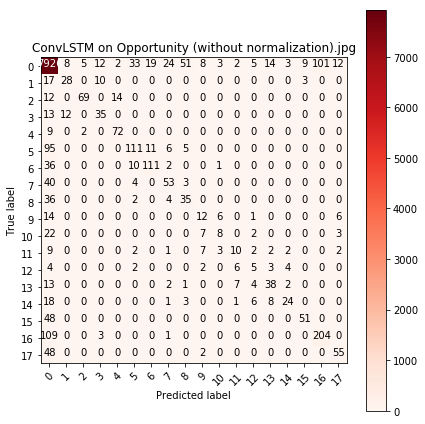

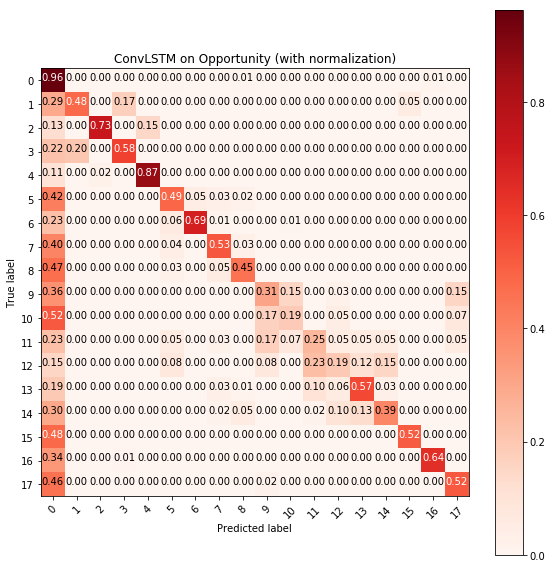

In [273]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('int') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test0, foo)
np.set_printoptions(precision=3)


# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix,classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],
                      title='ConvLSTM on Opportunity (without normalization).jpg')
plt.savefig("ConvLSTM on Opportunity (without normalization).jpg")

#Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17], normalize=True,
#                        title='Normalized confusion matrix')
                      title='ConvLSTM on Opportunity (with normalization)')
plt.savefig("ConvLSTM on Opportunity (with normalization).jpg")
plt.show()